# Ex 3. Separate inhibitory population

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**3.1.** Write down the total input to an excitatory and an inhibitory neuron. Show that the average input
to an excitatory neuron is equivalent to the input to a neuron in the model of exercise 2, for b = 0.

**Part 1.**
The total input to an excitatory neuron is comprised of inputs from inhibitory and excitatory neurons:
$$h_{i} = h_{exc} - h_{inh}$$
Firstly, we consider $h_{exc}$:
\begin{align}
h_{exc} = W \sigma_{exc}
 = \sum_{j}^{N} W_{ij}^{E \leftarrow E} \sigma_{j}(t)
 = \sum_{j}^{N} \frac{c}{N} \sum_{\mu}^{M} \xi_{i}^{\mu} \xi_{j}^{\mu} \sigma_{j}(t)
\end{align}
Secondly, we consider $h_{inh}$:
\begin{align}
h_{inh} = W \sigma_{inh}
 = \sum_{k}^{K} W_{ik}^{E \leftarrow I} \sigma_{k}^{I}(t)
 = \sum_{k}^{K} \frac{ca}{N_{I}} \sum_{\mu}^{M} \xi_{i}^{\mu} \sigma_{k}^{I}(t)
\end{align}
Hence, the total input to the excitatory neuron is:
\begin{align}
h_{i} = \sum_{j}^{N} W_{ij}^{E \leftarrow E} \sigma_{j}(t) - \sum_{k}^{N_{I}} W_{ik}^{E \leftarrow I} \sigma_{k}^{I}(t)
\end{align}

Analogously, the total input to the inhibitory neuron is equal to:
\begin{align}
h_{k} = \sum_{k} W_{ki}^{I \leftarrow E} \sigma_{k}(t) = \frac{1}{K} \sum_{k} \sigma_{k}(t),
\end{align}
where $k \in S$, where $S$ is the set of pre-synaptic neurons.


**Part 2.**
1. Inhibiting neurons have linear gain function and fire stochastically: $Prob(\sigma_k = +1| h_{k}^{inh}) = h_{k}^{inh}$, where k is an index of an inhibitory neuron $1 \le k \le N_{I}$.

2. Each inhibitory neuron $k$ recieves receives input from $K$ excitatory neurons. Connections are random and of equal weight $w_{ki}^{I \leftarrow E} = \frac{1}{K}$.
3. Thus, the input potential of the neuron k is $h_{k}^{inh} = \frac{1}{K} \sum_{j \in S}$, where S is the set of pre-synaptic neurons.
4. Connection from inhibitory neuron back to excitatory neuron $w_{ik}^{E \leftarrow I} = \frac{a}{N_I} \sum_{\mu} \xi_{i}^{\mu}$
5. The total input from inhibitory neuron to excitatory is, therefore, $h_{inh} = \sum_{k} w_{ik}^{E \leftarrow I} \sigma_{k} = \sum_{k} \frac{a}{N_I} \sum_{\mu} \xi_{i}^{\mu} \sigma_{k} = \frac{ca}{N_I} \sum_{k} \sum_{\mu} \xi_{i}^{\mu} \sigma_{k}$.
6. Putting everything together and considering that $k=j$ and $N=N_I$.
$$<h_{i}(t)> = \frac{c}{N} \sum_{\mu}^{M} \xi_{i}^{\mu} \sum_{j}^{N} \xi_{j}^{\mu} \sigma_{j}(t) - \frac{ca}{N} \sum_{j}^{N} \sum_{\mu}^{M} \xi_{i}^{\mu} $$
$$ = \frac{c}{N} \sum_{\mu}^{M} \sum_{j}^{N} \xi_{i}^{\mu} (\xi_{j}^{\mu} - a) \sigma_{j}(t)$$
Which is equivalent to the low-activity Hopfield model discussed in part 2:
$$<h_{i}(t)> = \sum_{j}^{N} w_{ij} \sigma_{j}(t)$$
$$ = \frac{c}{N} \sum_{j}^{N} \sum_{\mu}^{M} (\xi_{i}^{\mu}-b)(\xi_{j}^{\mu}-a) \sigma_{j}(t)$$
$$ = \frac{c}{N} \sum_{j}^{N} \sum_{\mu}^{M} \xi_{i}^{\mu}(\xi_{j}^{\mu}-a) \sigma_{j}(t), QED$$

In [2]:
np.tanh(-100)

-1.0

In [438]:
def generate_patterns(M, N, a):
    """
    Args:
        M: number of patterns
        N: number of neurons
    Output:
        Generates binary balanced random patterns.
    """
    patterns = np.random.choice([0, 1], size=(M, N), p=[1-a,a])
    return patterns

class ExcitatoryInhibitory:
    def __init__(self, beta, theta):
        self.theta = theta
        self.beta = beta
        self.k = 500
    
    def compute_EE_overlap(self, patterns, sigma, N, a):
        M = patterns.shape[0]
        distances = np.zeros(M)
        m_EE = np.zeros(M)
        c = 2/(a*(1-a))
        for mu in range(M):
            m_EE[mu] = c/N * np.dot(patterns[mu], sigma)
            distances[mu] = np.sum(patterns[mu] == sigma)
        return m_EE, distances
    
    def compute_hi_exc(self, patterns, m_EE):
        return np.dot(m_EE, patterns)
    
    def compute_hk(self, sigma, N, K, N_I):
        hk = np.zeros(N_I) # state_I initialised as zeros
        for i in range(N_I):
            chosen_neurons = np.random.choice(N, K)
            hk[i] = 1/K * np.sum(sigma[chosen_neurons])
        return hk
    
    def compute_IE_overlap(self, N_I, sigma_I):
        mean_activity_inhibitory = np.mean(sigma_I)
        return mean_activity_inhibitory
    
    def compute_hi_inh(self, patterns, mean_activity_inhibitory, a, N):
        c = 2/(a*(1-a))
        hi_inh = np.zeros(N)
        for i in range(N):
            #print(patterns[:,i]*mean_activity_inhibitory)
            hi_inh[i] = c*a*np.sum(patterns[:,i]*mean_activity_inhibitory)
        return hi_inh
    
    def compute_state_exc(self, hi):
        return np.tanh(hi - self.theta)
    
    def stoch_var_exc(self, state):
        firing_probability = 0.5 * (state + 1) 
        sigma = np.random.binomial(1, firing_probability) # P{σ_i(t) = +1 | S_i(t)}
        return sigma
    
    def stoch_var_inh(self, hk):
        sigma_I = np.random.binomial(1, hk) # P{σ_i(t) = +1 | S_i(t)}
        return sigma_I
    
    def hamming_distance(self, state1, state2, N):
        state1 = 2*state1 - 1
        state2 = 2*state2 - 1
        #print(np.dot(state2, state1))
        return (N - np.dot(state2, state1))/(2*N)
    
    '''
    def hamming_distance(self, dist, N):
        return (N-dist)/(2*N)
    '''
    
    def synchronous_simulation(self, sigma_E, sigma_I, patterns, N, N_I, K, a):
        store = {'overlaps': [],
                 'hamming_distances':[],
                 'excitatory_states':[],
                 'inhibitory_states':[],
                 'overs':[]}
        #store['inhibitory_states'].append(sigma_I)
        store['excitatory_states'].append(sigma_E)
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        for i in range(self.k):
            m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)
        
            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I)
            hi_inh = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi = hi_exc - hi_inh
            print(hi)

            hk = self.compute_hk(sigma_E, N, K, N_I)
            sigma_I = self.stoch_var_inh(hk)

            state_E = self.compute_state_exc(hi)
            sigma_E = self.stoch_var_exc(state_E)

            store['overlaps'].append(m_EE)
            store['overs'].append(np.dot(2*patterns-1, 2*state_E-1))
            store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
            #store['hamming_distances'].append((N-dist)/(2*N))
            store['excitatory_states'].append(sigma_E)
            store['inhibitory_states'].append(sigma_I)

        return store
    
    def asynchronous_simulation(self, sigma_E, sigma_I, patterns, N, N_I, K, a):
        store = {'overlaps': [],
                 'hamming_distances':[],
                 'excitatory_states':[],
                 'inhibitory_states':[],
                 'overs':[]}
        store['inhibitory_states'].append(sigma_I)
        store['excitatory_states'].append(sigma_E)
        store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
        store['overs'].append(np.dot(2*patterns-1, 2*sigma_E-1))
        for i in range(self.k):
            hk = self.compute_hk(sigma_E, N, K, N_I)
            sigma_I = self.stoch_var_inh(hk)

            m_EE, dist = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)

            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I)
            hi_inh = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi = hi_exc - hi_inh

            state_E = self.compute_state_exc(hi)
            sigma_E = self.stoch_var_exc(state_E)

            store['overlaps'].append(m_EE)
            store['overs'].append(np.dot(patterns, state_E))
            store['hamming_distances'].append(self.hamming_distance(sigma_E, patterns, N))
            #store['hamming_distances'].append((N-dist)/(2*N))
            store['excitatory_states'].append(sigma_E)
            store['inhibitory_states'].append(sigma_I)

        return store
    

In [439]:
# Parameters
N = 300  # Number of excitatory neurons
N_I = 80 # Number of inhibitory neurons
M = 10   # Number of patterns
K = 60   # Connections from excitatory to inhibitory
a = 0.1  # Activity level
theta = 1 # Threshold
beta = 4
num_steps = 100

patterns = generate_patterns(M, N, a)

# Initial random states
state_E = np.random.choice([0, 1], size=N, p=[1-a, a])
state_I = np.random.choice([0, 1], size=N_I, p=[1-a, a])
#initial_state = patterns[0].copy()

model = ExcitatoryInhibitory(beta, theta)
store = model.synchronous_simulation(state_E, state_I, patterns, N, N_I, K, a)


[ 0.11111111  0.12962963  0.05555556 -0.16666667 -0.09259259  0.
  0.18518519  0.          0.          0.          0.05555556  0.
  0.33333333  0.24074074  0.          0.          0.          0.
  0.          0.2037037   0.          0.16666667  0.         -0.09259259
  0.12962963  0.          0.2037037  -0.09259259  0.05555556  0.05555556
  0.05555556  0.11111111  0.05555556  0.05555556  0.          0.11111111
  0.12962963  0.          0.          0.11111111  0.          0.05555556
  0.          0.          0.05555556  0.          0.46296296  0.11111111
 -0.11111111 -0.09259259  0.2037037   0.24074074  0.03703704  0.
  0.          0.05555556  0.05555556  0.          0.05555556 -0.16666667
  0.          0.05555556  0.05555556  0.03703704  0.05555556 -0.09259259
  0.18518519  0.12962963 -0.05555556  0.12962963  0.03703704  0.
  0.18518519  0.          0.33333333  0.18518519  0.12962963  0.01851852
  0.          0.05555556  0.2037037  -0.09259259  0.          0.05555556
  0.24074074  0.  

In [427]:
#print(store["excitatory_states"])

In [428]:
print(np.sum(np.array(store['excitatory_states']), axis=1))

[ 35  40  30  23  37  40  32  39  56  82  74  54  39  31  26  24  34  33
  42  41  35  24  31  39  22  43  61  74  76  68  51  48  41  37  48  72
  85  56  56  53  52  52  57  74  78  70  79  63  56  61  75  68  67  52
  60  65  61  65  59  62  65  59  61  72  86  75  62  53  74  80 102  88
  84  59  29  34  48  55  39  35  41  38  43  36  29  34  24  26  34  44
  36  32  35  40  29  35  42  37  22  30  36  38  36  41  63  42  25  33
  31  37  40  62  49  39  37  36  26  24  47  51  47  36  27  31  28  36
  43  50  40  32  31  40  33  39  45  59  81  97  96 103 102  95  75  71
  70  77  80  88  99  95  75  70  72  59  52  55  63  52  54  65  73  75
  62  46  51  59  61  61  68  65  70  61  68  63  54  38  36  37  40  39
  45  41  44  36  47  42  32  32  31  44  39  34  26  42  58  90  97  90
  93  89  88  68  40  34  39  38  50  51  47  33  40  36  30  26  30  33
  47  48  39  24  31  52  52  32  20  24  37  57  79  69  71  89  88  68
  64  53  33  38  29  39  45  41  33  33  21  38  5

In [429]:
overlaps = np.array(store['overlaps'])
print("Shape of overlaps:", overlaps.shape)

hamming_distances = np.array(store["hamming_distances"])
print("Shape of hamming distances:", hamming_distances.shape)

excitatory_states = np.array(store["excitatory_states"])
print("Shape of the excitatory states array:", excitatory_states.shape)

inhibitory_states = np.array(store["inhibitory_states"])
print("Shape of inhibitory states array:", inhibitory_states.shape)

#overs = np.array(store['overs'])
#print(overs.shape)


Shape of overlaps: (500, 10)
Shape of hamming distances: (501, 10)
Shape of the excitatory states array: (501, 300)
Shape of inhibitory states array: (500, 80)


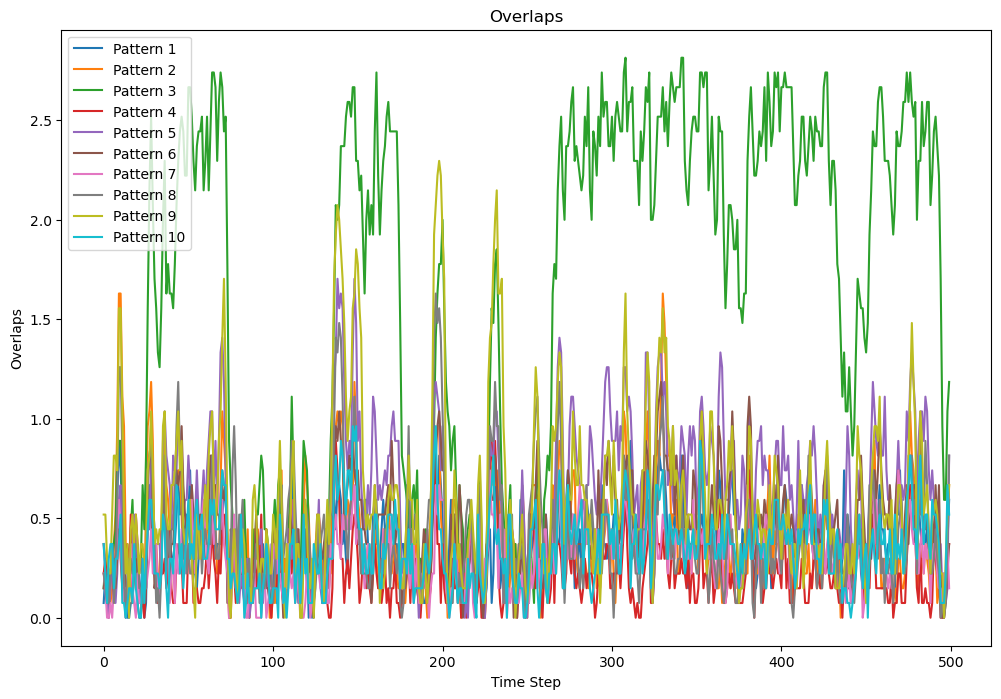

In [430]:
# Plotting the overlaps
plt.figure(figsize=(12, 8))
for i in range(overlaps.shape[1]):
    plt.plot(overlaps[:, i], label=f'Pattern {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Overlaps')
plt.title('Overlaps')
plt.legend()
plt.show()


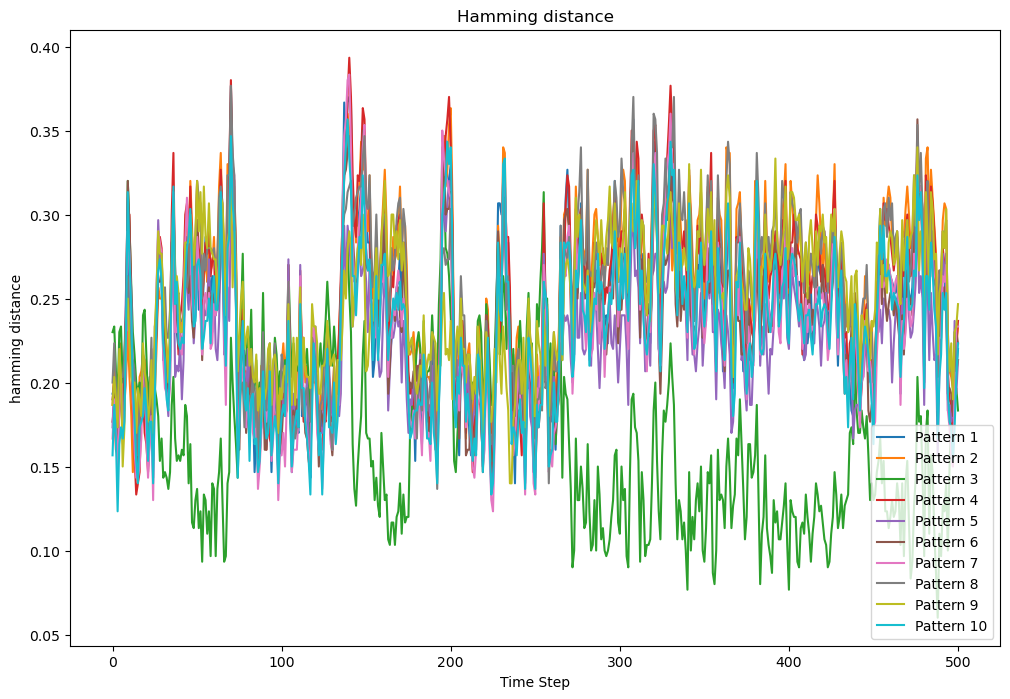

In [431]:
# Plotting the overlaps
plt.figure(figsize=(12, 8))
for i in range(hamming_distances.shape[1]):
    plt.plot(hamming_distances[:, i], label=f'Pattern {i+1}')
plt.xlabel('Time Step')
plt.ylabel('hamming distance')
plt.title('Hamming distance')
plt.legend()
plt.show()


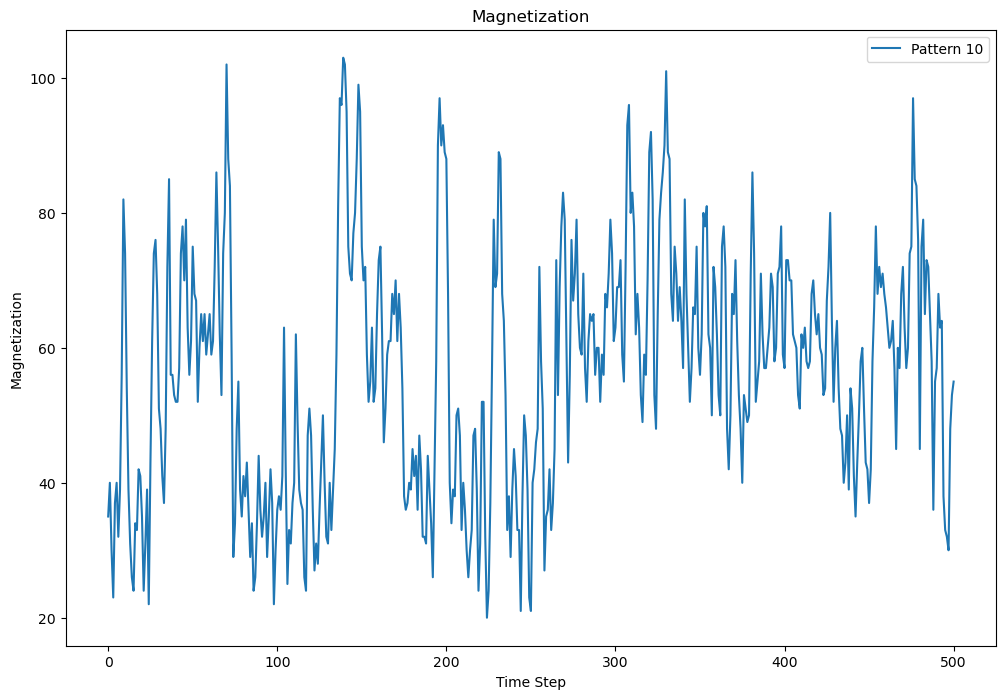

In [432]:
# Plotting the overlaps
excitatory_states_magnetization = np.sum(excitatory_states, axis=1)
#print(excitatory_states)
#print(excitatory_states_magnetization)

plt.figure(figsize=(12, 8))
plt.plot(excitatory_states.sum(1), label=f'Pattern {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Magnetization')
plt.title('Magnetization')
plt.legend()
plt.show()


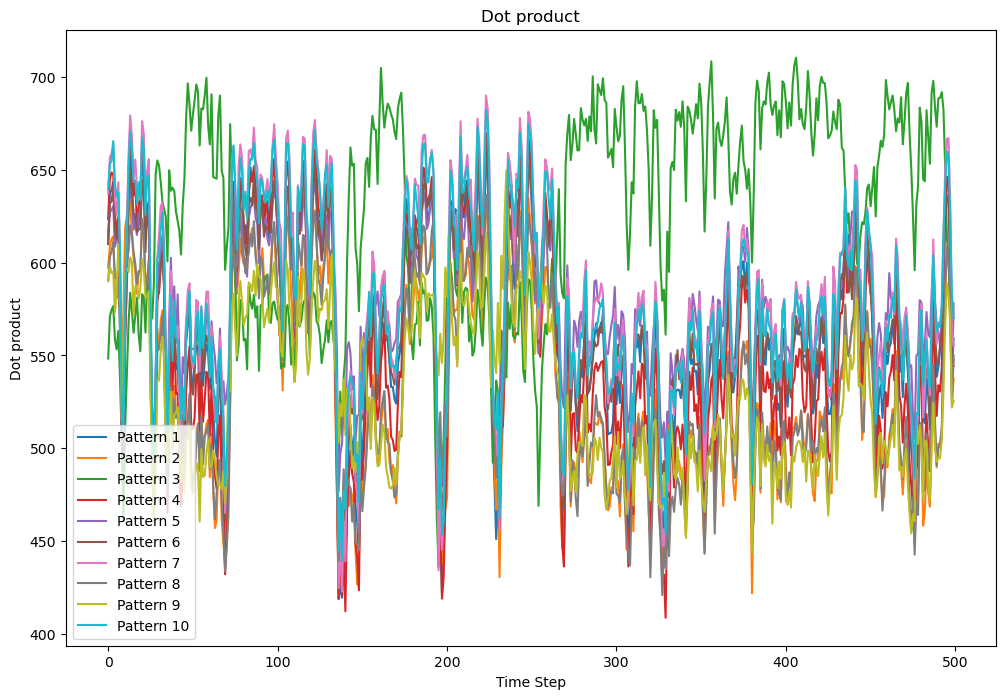

In [433]:
overs = np.array(store['overs'])

# Plotting the overlaps
plt.figure(figsize=(12, 8))
for i in range(overs.shape[1]):
    plt.plot(overs[:, i], label=f'Pattern {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Dot product')
plt.title('Dot product')
plt.legend()
plt.show()


**3.3.** Studying the storage capacity

In [434]:
def retrieve_patterns(ham_dist, m, N):
    """
    Retrieve the stored patterns.
    """
    M_max = 0
    for i in range(m):
        if ham_dist[i].any() < 0.05:
            M_max += 1
    return M_max / N

(501, 5)
(501, 38)
(501, 71)
(501, 104)
(501, 137)
(501, 170)
(501, 203)
(501, 236)
(501, 269)
(501, 302)
(501, 335)
(501, 368)
(501, 401)
(501, 434)
(501, 467)
(501, 500)


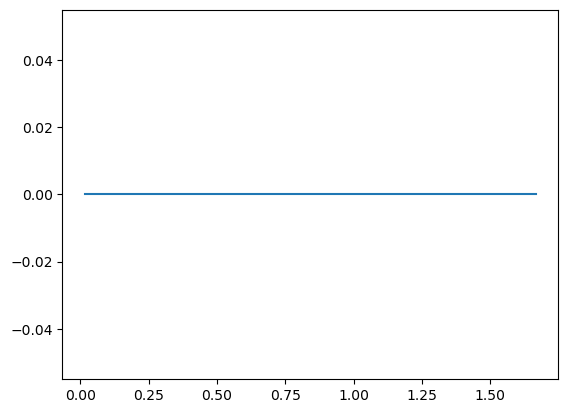

In [435]:
M = np.linspace(5,500,16)
retrieved_patterns = np.zeros(len(M))
a = 0.1
initial_state_E = np.random.choice([0, 1], size=N, p=[1-a, a])
initial_state_I = np.random.choice([0, 1], size=N, p=[1-a, a])

for i,m in enumerate(M):
    patterns = generate_patterns(int(m), N, a)
    store = model.synchronous_simulation(initial_state_E, initial_state_I, patterns, N, N_I, K, a)
    hd = np.stack(store['hamming_distances'])
    print(hd.shape)
    retrieved_patterns[i] = retrieve_patterns(hd, int(m), N)

plt.figure()
plt.plot(M/N, retrieved_patterns, label='Inhibitory')
plt.show() 

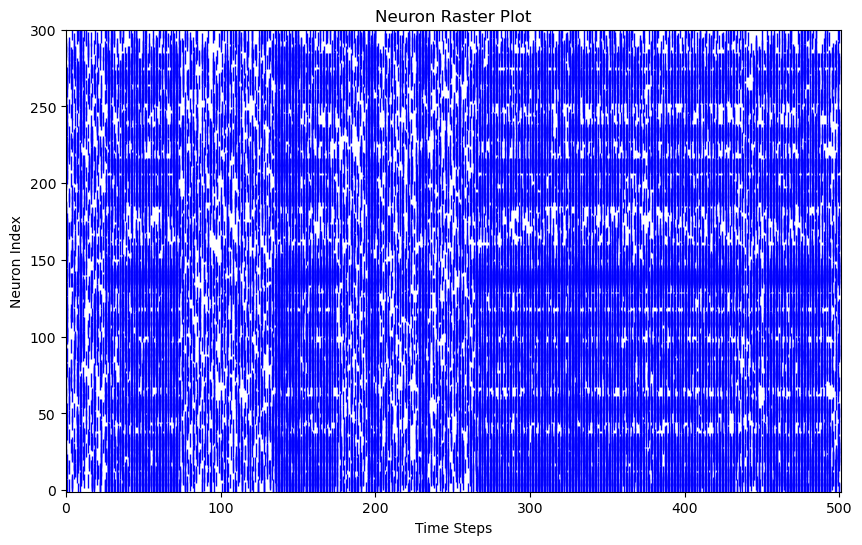

In [437]:
# Plotting the raster plot

def plot_neuron_spiking_from_array(neuron_spikes):
    """
    Plots a raster plot of neuron spiking activity from a binary array.

    Args:
        neuron_spikes (numpy array): Array of shape (time_steps, neuron_states) where each element is either 0 or 1.
    """
    # Setting up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    num_neurons = neuron_spikes.shape[1]
    time_steps = neuron_spikes.shape[0]
    
    # Iterate over each neuron
    for neuron_idx in range(num_neurons):
        # Extract spike times for this neuron
        spike_times = np.where(neuron_spikes[:, neuron_idx] == 1)[0]
        # Plot each spike time for the current neuron
        ax.plot(spike_times, [neuron_idx] * len(spike_times), 'b|', markersize=10)

    ax.set_xlim(0, time_steps)
    ax.set_ylim(-1, num_neurons)
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Neuron Index')
    ax.set_title('Neuron Raster Plot')
    plt.show()

plot_neuron_spiking_from_array(excitatory_states)

# Draft

In [135]:
import numpy as np

class ExcitatoryInhibitory:
    def __init__(self, beta, theta, N, N_I, K, patterns, a, k=100):
        self.theta = theta
        self.beta = beta
        self.N = N
        self.N_I = N_I
        self.K = K
        self.patterns = patterns
        self.a = a
        self.k = k
        self.c = 2 / (a * (1 - a))

    def compute_hi_exc(self, sigma_E):
        M = self.patterns.shape[0]
        m_EE = np.zeros(M)
        for mu in range(M):
            m_EE[mu] = self.c / self.N * np.dot(self.patterns[mu], sigma_E)
        return np.dot(m_EE, self.patterns)
    
    def compute_hk(self, sigma_E):
        hk = np.zeros(self.N_I)
        for i in range(self.N_I):
            chosen_neurons = np.random.choice(self.N, self.K, replace=False)
            hk[i] = np.mean(sigma_E[chosen_neurons])
        return hk
    
    def compute_hi_inh(self, mean_activity_inhibitory):
        return self.c * self.a * 2 * mean_activity_inhibitory
    
    def compute_state(self, hi):
        return np.tanh(hi - self.theta)
    
    def stochastic_update(self, hi):
        firing_probability = 0.5 * (1 + np.tanh(self.beta * (hi - self.theta)))
        return np.random.binomial(1, firing_probability, size=hi.shape)
    
    def synchronous_simulation(self):
        sigma_E = self.stochastic_update(np.zeros(self.N))  # Initial state for excitatory neurons
        sigma_I = self.stochastic_update(np.zeros(self.N_I))  # Initial state for inhibitory neurons
        overs = []
        hamming_distances = []
        for _ in range(self.k):
            hi_exc = self.compute_hi_exc(sigma_E)
            hk = self.compute_hk(sigma_E)
            sigma_I = self.stochastic_update(hk)
            mean_activity_inhibitory = np.mean(sigma_I)
            hi_inh = self.compute_hi_inh(mean_activity_inhibitory)
            hi = hi_exc + hi_inh
            sigma_E = self.stochastic_update(hi)
            state_E = self.compute_state(sigma_E)
            overs.append(np.dot(patterns, state_E))
            hamming_distances.append(self.hamming_distance(state_E, patterns, N))

        return sigma_E, sigma_I, overs, hamming_distances
    
    def hamming_distance(self, state1, state2, N):
        state1 = 2*state1 - 1
        state2 = 2*state2 - 1
        print(state1)
        print(state2)
        return (N - np.dot(state2, state1))/(2*N)
    
    def asynchronous_simulation(self):
        overs = []
        hamming_distances = []
        
        sigma_E = self.stochastic_update(np.zeros(self.N))  # Initial state for excitatory neurons
        sigma_I = self.stochastic_update(np.zeros(self.N_I))  # Initial state for inhibitory neurons

        for _ in range(self.k):
            for i in np.random.permutation(self.N):  # Update excitatory neurons in random order
                hi_exc = self.compute_hi_exc(sigma_E)
                mean_activity_inhibitory = np.mean(sigma_I)
                hi_inh = self.compute_hi_inh(mean_activity_inhibitory)
                hi = hi_exc[i] + hi_inh
                sigma_E[i] = self.stochastic_update(np.array([hi]))

            for i in np.random.permutation(self.N_I):  # Update inhibitory neurons in random order
                hk = self.compute_hk(sigma_E)
                sigma_I[i] = self.stochastic_update(np.array([hk[i]]))
            state_E = self.compute_state(sigma_E)
            overs.append(np.dot(patterns, state_E))
            hamming_distances.append(self.hamming_distance(state_E, patterns, N))

        return sigma_E, sigma_I, overs, hamming_distances

# Example usage:
N = 300
N_I = 80
K = 60
M = 10  # Number of patterns
patterns = np.random.randint(0, 2, (M, N))
a = np.mean(patterns)
theta = 0.1
beta = 0.1

network = ExcitatoryInhibitory(beta, theta, N, N_I, K, patterns, a)
sigma_E, sigma_I, overs, hamming_distances = network.synchronous_simulation()
print("Synchronous Final States:", sigma_E, sigma_I)
#sigma_E, sigma_I, overs, hamming_distances = network.asynchronous_simulation()
print("Asynchronous Final States:", sigma_E, sigma_I)


[ 0.43259574  0.43259574  0.43259574  0.43259574  0.43259574 -1.19933599
  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574
  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574
  0.43259574 -1.19933599  0.43259574  0.43259574  0.43259574  0.43259574
  0.43259574 -1.19933599  0.43259574  0.43259574  0.43259574 -1.19933599
  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574
  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574 -1.19933599
  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574
  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574
  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574
  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574
  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574
  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574  0.43259574
  0.43259574  0.43259574  0.43259574  0.43259574  0

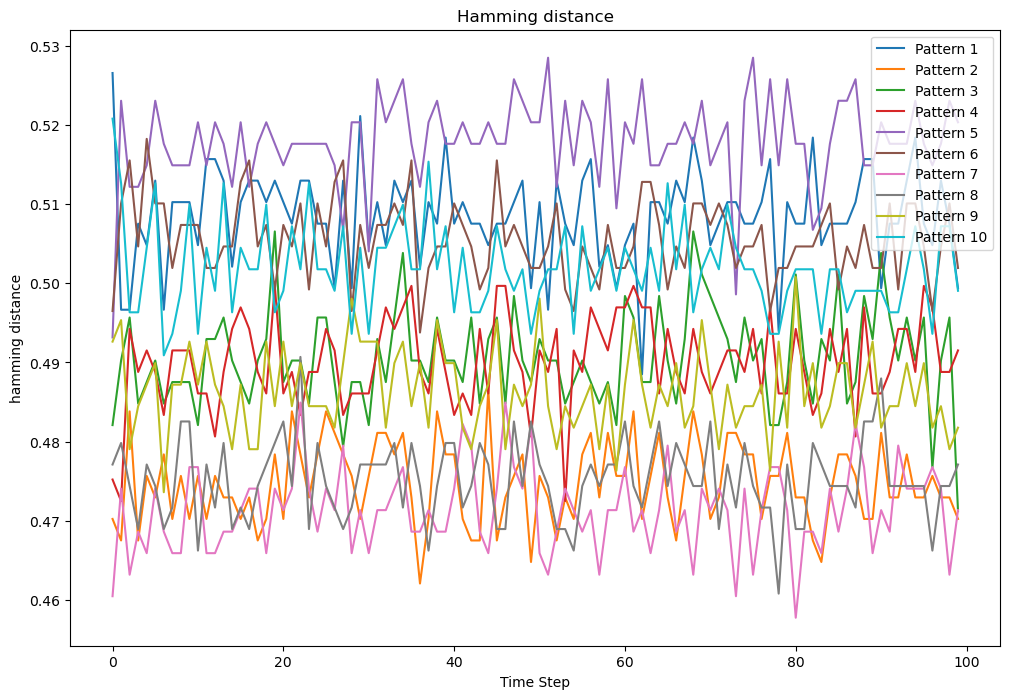

In [127]:
hamming_distances = np.array(hamming_distances)

# Plotting the overlaps
plt.figure(figsize=(12, 8))
for i in range(hamming_distances.shape[1]):
    plt.plot(hamming_distances[:, i], label=f'Pattern {i+1}')
plt.xlabel('Time Step')
plt.ylabel('hamming distance')
plt.title('Hamming distance')
plt.legend()
plt.show()


In [ ]:
'''
    def asynchronous_simulation(self, state_E, patterns, N, N_I, K, a):
        sigma_I = np.zeros(N_I)
        store = {'overlaps': [],
                 'hamming_distances':[],
                 'excitatory_states':[],
                 'inhibitory_states':[],
                 'overs':[]}
        store['inhibitory_states'].append(sigma_I)
        store['excitatory_states'].append(state_E)
        store['hamming_distances'].append(self.hamming_distance(state_E, patterns, N))
        store['overs'].append(np.dot(2*patterns-1, 2*state_E-1))
        sigma_I = self.stoch_var_inh(sigma_I)
        for i in range(self.k):
            sigma_E = self.stoch_var_exc(state_E)
            m_EE = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)

            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I)
            hi_inh = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi = self.compute_hi(hi_inh, hi_exc)

            hk = self.compute_hk(sigma_E, N, K, N_I)
            sigma_I = self.stoch_var_inh(hk)

            state_E = self.compute_state_exc(hi)

            store['overlaps'].append(m_EE)
            store['overs'].append(np.dot(2*patterns-1, 2*state_E-1))
            store['hamming_distances'].append(self.hamming_distance(state_E, patterns, N))
            store['excitatory_states'].append(state_E)
            store['inhibitory_states'].append(sigma_I)

        return store
    
    def synchronous_simulation(self, state_E, patterns, N, N_I, K, a):
        store = {'overlaps': [],
                 'hamming_distances':[],
                 'excitatory_states':[],
                 'inhibitory_states':[]}
        #store['inhibitory_states'].append(sigma_I)
        store['excitatory_states'].append(state_E)
        store['hamming_distances'].append(self.hamming_distance(state_E, patterns, N))
        for i in range(self.k):
            sigma_E = self.stoch_var_exc(state_E)
            m_EE = self.compute_EE_overlap(patterns, sigma_E, N, a)
            hi_exc = self.compute_hi_exc(patterns, m_EE)

            hk = self.compute_hk(sigma_E, N, K, N_I)
            sigma_I = self.stoch_var_inh(hk)
            mean_activity_inhibitory = self.compute_IE_overlap(N_I, sigma_I)
            hi_inh = self.compute_hi_inh(patterns, mean_activity_inhibitory, a, N)
            hi = self.compute_hi(hi_inh, hi_exc)
            
            state_E = self.compute_state_exc(hi)

            store['overlaps'].append(m_EE)
            store['hamming_distances'].append(self.hamming_distance(state_E, patterns, N))
            store['excitatory_states'].append(state_E)
            store['inhibitory_states'].append(sigma_I)

        return store

    '''